<a href="https://colab.research.google.com/github/ankur26/SalaryPrediction/blob/master/Salary%20Prediction%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

This project will uncover some findings on a baseline model for salary predictions based of the jobs described for the same. This will help the finance and HR teams to have a base line of pay set to not go beyond the value given by our model when new employee/current employee salary negotiations happen thereby reducing the risk of overpaying a person more than expected. This also can be used on the flipside by current employees as a tool to see whether they are getting paid according to what industry standards expect your pay to be.

In [0]:
#import your libraries
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
%matplotlib inline
sns.set()
import warnings
warnings.simplefilter("ignore")
#etc

#your info here
__author__ = "Ankur Bhatkalkar"
__email__ = "ab7869@nyu.edu"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#load the data into a Pandas dataframe
train_features_df = pd.read_csv('/content/drive/My Drive/Instructions_and_Notebook/data/train_features.csv')
train_target_df = pd.read_csv('/content/drive/My Drive/Instructions_and_Notebook/data/train_salaries.csv')
test_df = pd.read_csv('/content/drive/My Drive/Instructions_and_Notebook/data/test_features.csv')

In [0]:
#Merge the data on the jobId to get a single dataset for EDA
train_df = pd.merge(train_features_df,train_target_df,how="inner",on="jobId")

In [119]:
train_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


# **A brief description of our features within the dataset**
1. **jobID**: The ID of the job.
2. **companyId**: The company for which the person is working encoded for security purposes.
3. **jobType**: The position of the person in the job
4. **degree**: Degree of the job holder.
5. **major**:Major in which the degree is held.
6. **industry**:The industry of the job.
7. **yearsExperience**:The amount of experience the person has.
8. **milesFromMetropolis**: Distance from nearest metropolis
9. **salary**: The salary of the person and the value which will be predicited. Defined in thousands.

In [120]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [0]:
features = train_df.columns.drop(["jobId"]).values

In [122]:
train_df.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [123]:
train_df.describe(include=['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362685083832,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


Looking at the summary statistics for the values in the dataset we can see that most of the people have no formal education. And we can see just by looking at the frequency counts for each of the values in the data that the values are very evenly distributed across the dataset.

### ---- 3 Clean the data ----

**Check for duplicates across training and test sets**

In [124]:
train_df.duplicated().sum()

0

In [125]:
test_df.duplicated().sum()

0

**Visualize the target variable**

In [0]:
def plot_histogram(df,feature=None):
    if feature==None:
        print("Give a feature value for the distribution")
        return
    if df[feature].dtype == "int64" or df[feature].dtype == "float":
        fig = plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        sns.distplot(df[feature])
        plt.subplot(1,2,2,)
        sns.boxplot(df[feature])
        fig.savefig("/content/drive/My Drive/Instructions_and_Notebook/"+feature+"histogram.png")
    elif df[feature].dtype == "object":
        fig = plt.figure()
        sns.catplot(x=feature,kind="count",data=df,aspect=2.5)
        plt.xticks(rotation=90)
        fig.savefig("/content/drive/My Drive/Instructions_and_Notebook/"+feature+"histogram.png")
    # plt.xlabel(feature)
    # plt.ylabel("Count")
    plt.title("Distribution for "+feature)
    return

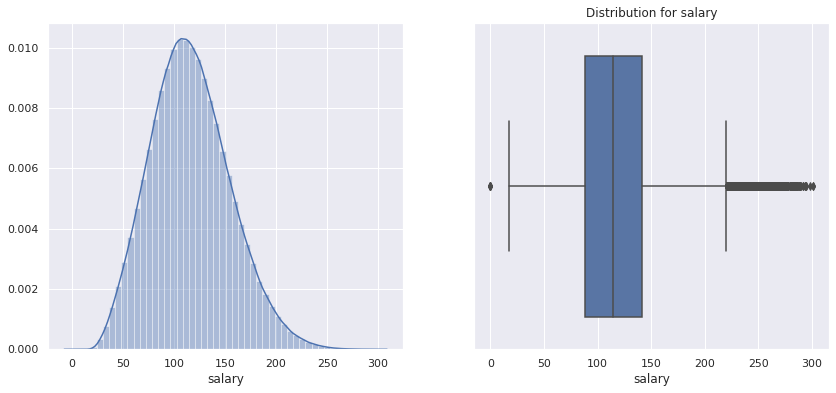

In [127]:
plot_histogram(train_df,"salary")

**Use IQR to identify the outliers and look into it further**

In [0]:
def get_stats(df,feature=None):
    if feature:
        if type(df) == type(pd.DataFrame()):
            stat = df[feature].describe()
            IQR = stat['75%'] - stat['25%']
            upper = stat['75%'] + 1.5*IQR
            lower = stat['25%'] - 1.5*IQR
            return stat,upper,lower
        else:
            print("Wrong input for dataframe")
    else:
        print("No feature passed")
    return

In [129]:
stat,lower,upper = get_stats(train_df,"salary")
print("Suspected outliers are beyond {} and below {}".format(upper,lower))

Suspected outliers are beyond 8.5 and below 220.5


Checking outliers below 8.5

In [130]:
train_df[train_df['salary']<8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


The data does appear to be corrupt as the positions do not mention any volunteer or unpaid work hence these instances need to be removed from the training set.

In [0]:
train_df = train_df[train_df.salary > 8.5]

Checking outliers beyond 220.5

In [132]:
train_df[train_df.salary>220.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
...,...,...,...,...,...,...,...,...,...
998516,JOB1362685406203,COMP29,CFO,MASTERS,ENGINEERING,WEB,14,46,227
999249,JOB1362685406936,COMP30,CEO,NONE,NONE,OIL,17,10,223
999280,JOB1362685406967,COMP2,CFO,BACHELORS,BUSINESS,SERVICE,21,0,228
999670,JOB1362685407357,COMP20,CEO,DOCTORAL,LITERATURE,SERVICE,24,14,233


As you can see there are over 7000 values that are beyond and we can see that it amounts to 0.7% of the total data which is not a lot hence we will go forward with dropping the data.


In [0]:
train_df = train_df[train_df.salary<=220.5]

In [134]:
train_df.shape #Checking final size of the dataset

(992878, 9)

In [0]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

### ---- 4 Explore the data (EDA) ----

In [0]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features


In [0]:
def plot_feature(df,feature,target):
    fig = plt.figure(figsize=(16,16))
    plt.subplot(2,1,1)
    if df[feature].dtype=="int64" or df[feature].dtype =="float64":
        sns.distplot(df[feature])
    else:
        df[feature].value_counts().sort_values().plot()
    plt.title("Distribution of "+feature)
    plt.xlabel(feature)
    plt.ylabel("counts")
    plt.xticks(rotation=45)
    # Plotting correlation with target feature
    plt.subplot(2,1,2)
    
    if df[feature].dtype=="int64" or df[feature].dtype=="float64":
        sns.regplot(x=feature,y=target,data=df)
    else:
        order = df.groupby(feature).mean().sort_values(target).reset_index()[feature].values
        sns.boxplot(x=feature,y=target,data=df,order=order)
    plt.title("Correlation of "+feature+" with "+ target)
    plt.xlabel(feature)
    plt.ylabel(target)
    if feature =="companyId" or feature=="degree_in_major":
        plt.xticks(rotation=90)

    fig.savefig("/content/drive/My Drive/Instructions_and_Notebook/"+feature+"_plot.png")

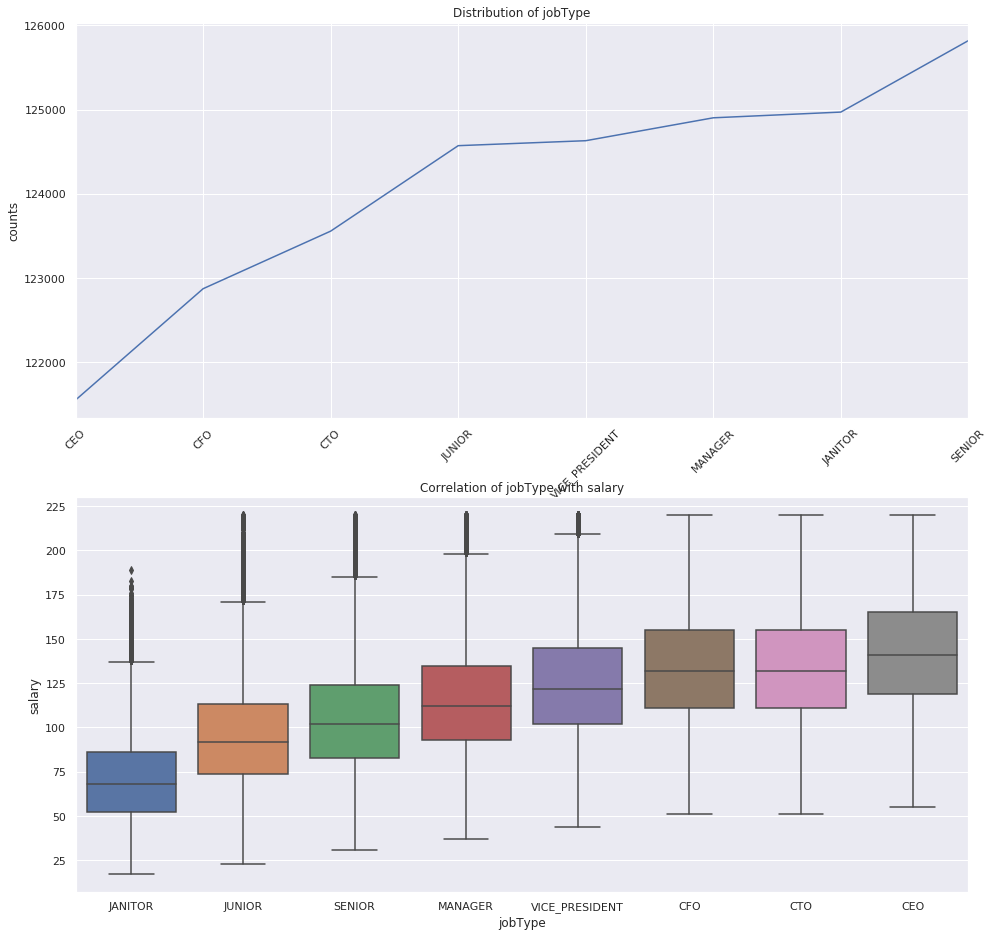

In [137]:
plot_feature(train_df,"jobType","salary")

Looking at the distribution we see that jobType increases linearly with the position as it is clear that C level executives will get paid the highest salaries

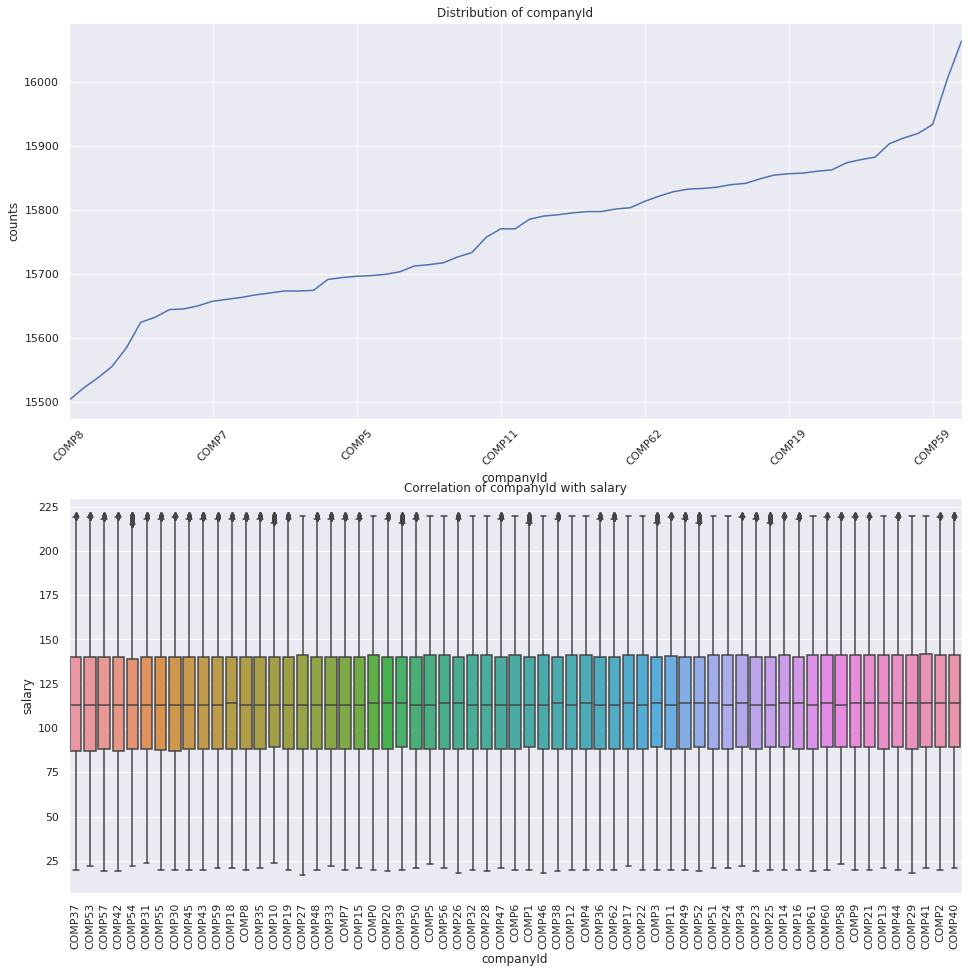

In [138]:
plot_feature(train_df,"companyId","salary")

Looks like the salary has very low variability across the companies hence when modeling we can drop this feature as it will not contribute a lot to the output.

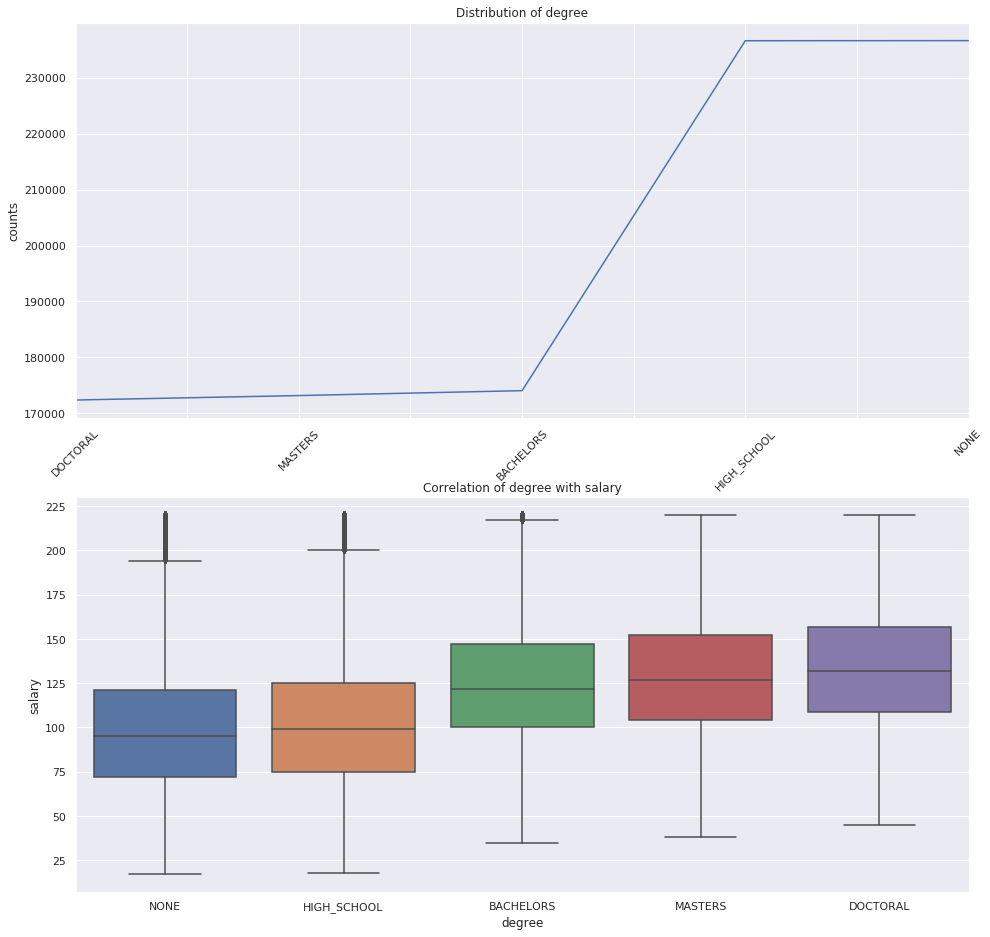

In [139]:
plot_feature(train_df,"degree","salary")

Here you can see a jump in salary from high school education to a bachelors but the people having high school and no education are almost equal in counts to bachelors, masters and doctorals combined. This also follows the intuition of higher degrees getting paid higher and lesser people going for further education

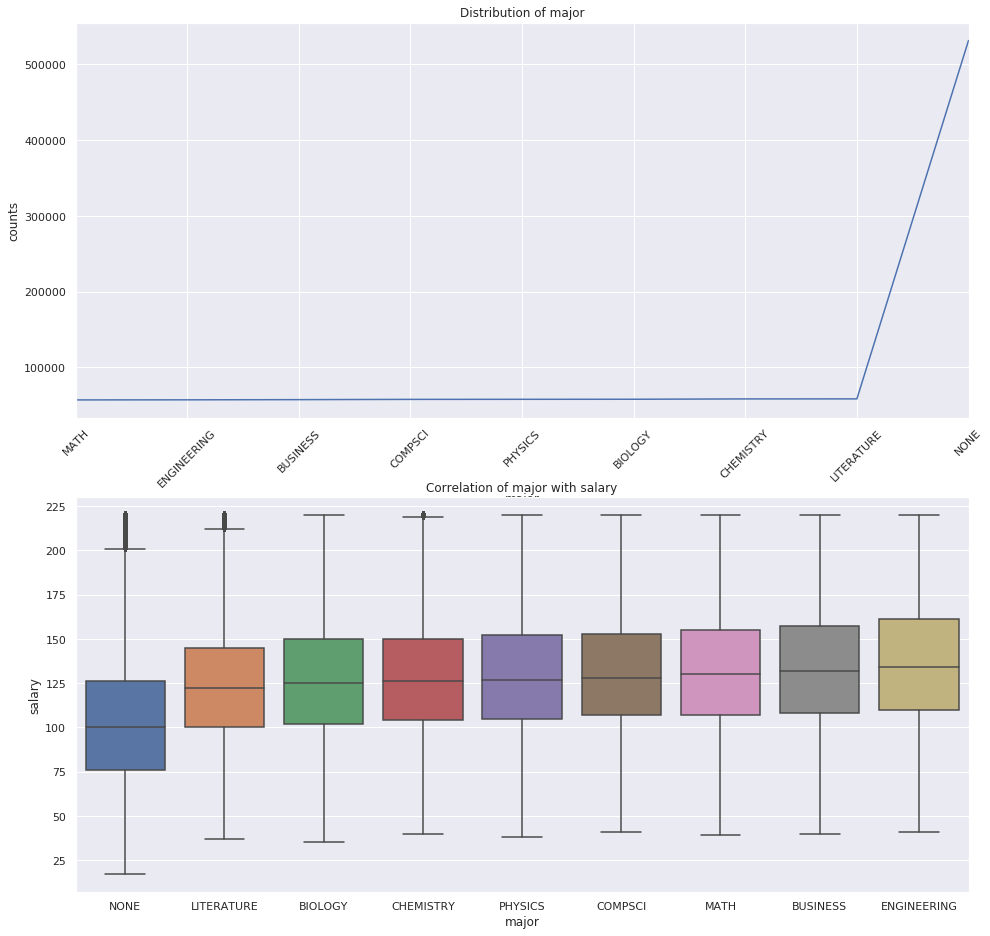

In [140]:
plot_feature(train_df,"major","salary")

We can again see that there are much more people with no education and there is a good jump in average salary if you have a degree vs not having a degree. Here we see that engineering,business and math majors get paid the most salaries on average.

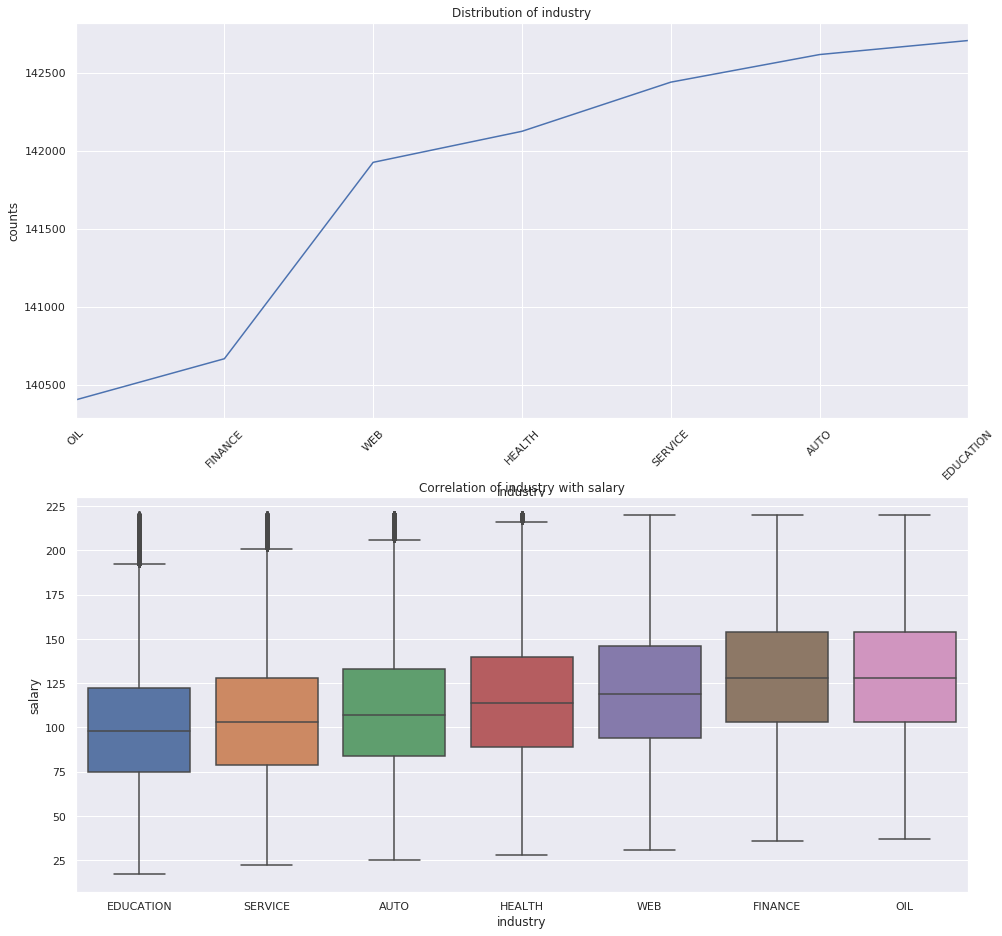

In [141]:
plot_feature(train_df,"industry","salary")

Here also the industry which you are in has a correlation to getting a higher salary. Also we can see that oil and finance industries get paid the highest at an almost equal margin.


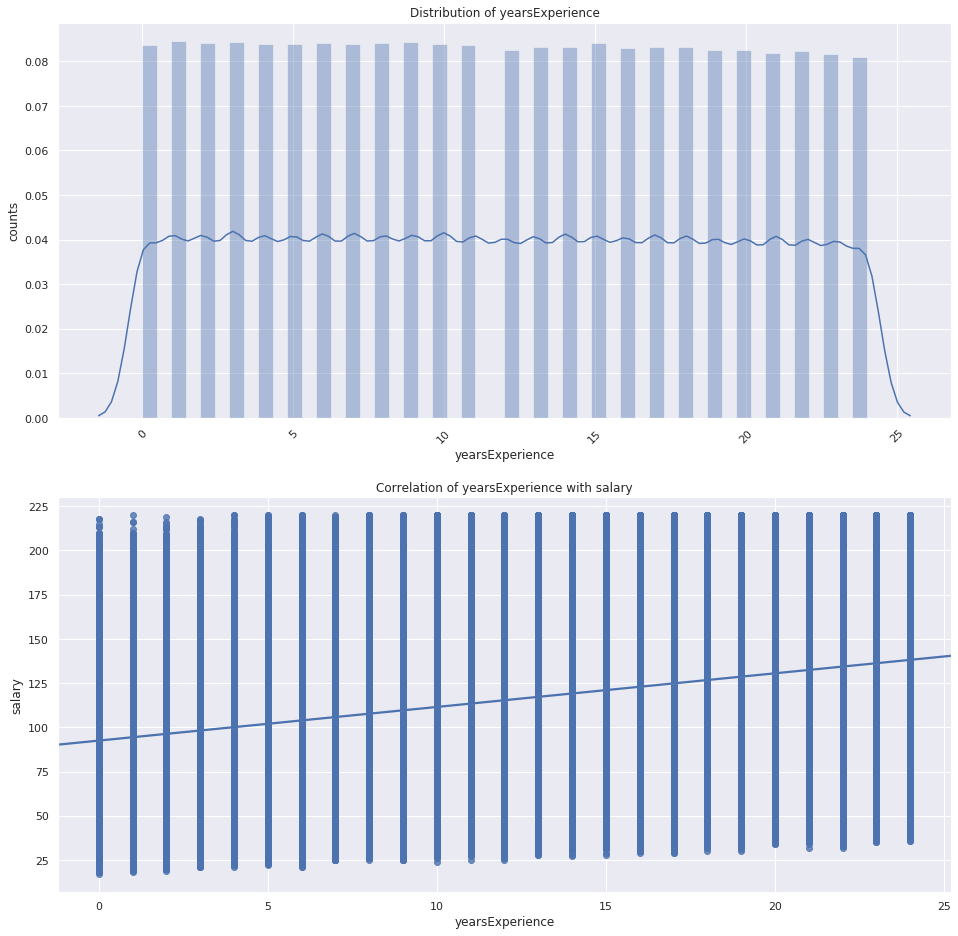

In [142]:
plot_feature(train_df,"yearsExperience","salary")

Years of experience has a clear positive correlation with the salary and it follows general intuition that higher experience is equivalent to higher salary

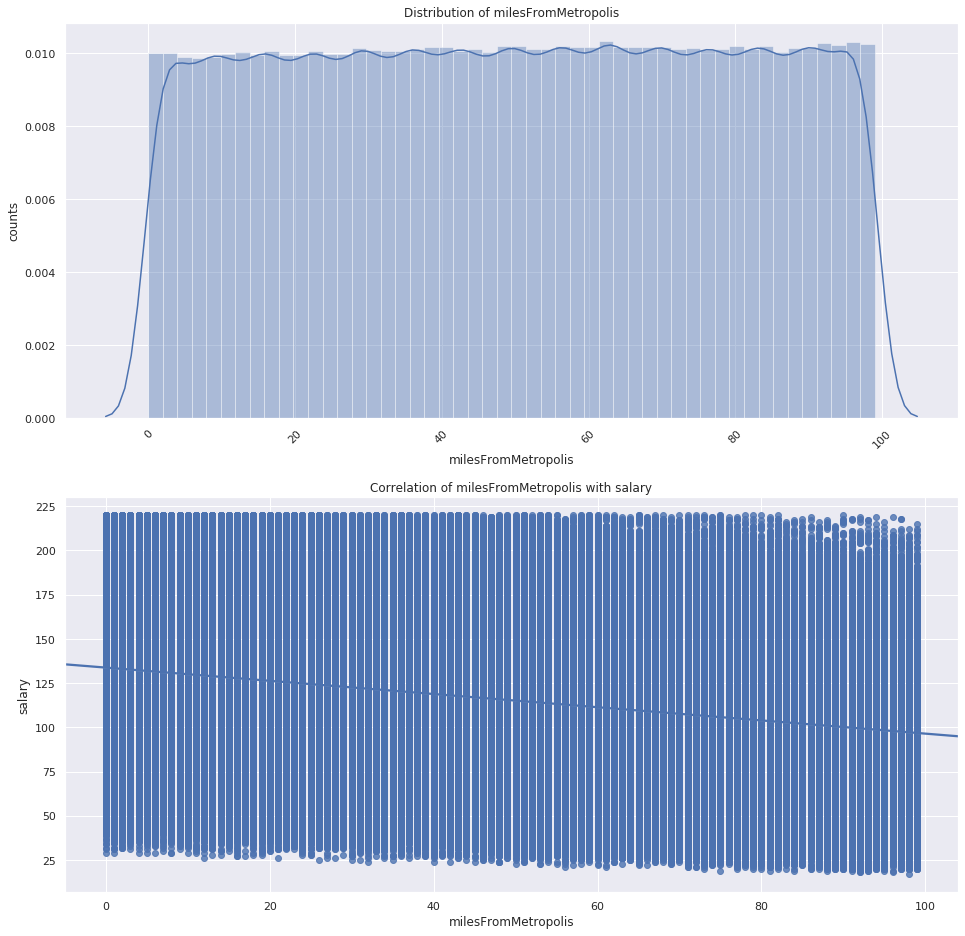

In [143]:
plot_feature(train_df,"milesFromMetropolis","salary")

As we can see there is a negative correlation with the miles from nearest metropolis, which does follow as cities away tend to have lower expenses hence amount to lower average salaries.

In [0]:
def get_feature_types(df):
    feature_types = df.dtypes
    numerical = feature_types[(feature_types=="float64")|(feature_types=="int64")].index.values
    categorical = feature_types[feature_types=="object"].index.values
    return numerical,categorical

In [0]:
numerical,categorical = get_feature_types(train_df)

In [146]:
numerical

array(['yearsExperience', 'milesFromMetropolis', 'salary'], dtype=object)

In [147]:
categorical

array(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry'],
      dtype=object)

### ---- 5 Establish a baseline ----

In [0]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation


#Baseline model evaluation

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5,shuffle=True)
cross_val_error = []
for train,test in kf.split(train_df):
    train_set = train_df.iloc[train]
    mean_salary_by_industry = train_set.groupby("industry").mean().reset_index()
    mean_salary_by_industry.drop(["yearsExperience","milesFromMetropolis"],axis=1,inplace=True)
    key_val_pair ={}
    for index,row in mean_salary_by_industry.iterrows():
        key_val_pair[row["industry"]]=row["salary"]
    test_features =  train_df.drop("salary",axis=1).iloc[test]
    test_target = train_df.salary.iloc[test]
    predictions = test_features["industry"].apply(lambda x : key_val_pair[x])
    cross_val_error.append(mean_squared_error(test_target,predictions))

In [149]:
np.mean(cross_val_error)

1289.540150665956

In [150]:
cross_val_error

[1283.9917136422923,
 1291.8370608724422,
 1289.1485655896772,
 1294.5817731686568,
 1288.1416400567107]

Looking at the baseline model of using just the average value across each industry we can predict the estimate of a salary by an error of 36k . But 36k is a huge margin as that margin covers the range of salaries between a junior postion to a vice president positon as an example so this is not a good enough measure to predict the salary .


Before making a solution we need to make the data compatible with the machine learning model hence we need to make all the inputs numerical in the dataset

1. We will be dropping the values jobId and CompanyId as they do not contribute in the prediction of salary.
2. We need to encode the jobType,Degree,Major,Industry and capture the correlation that a higher value will have a higher salary hence we will be using Ordinal Encoding to assign values to the class.

In [0]:
def ordinal_encode(df,feature,target):
    means = df.groupby(feature).mean().sort_values(target).reset_index()
    output_mapper = {}
    for index,row in means.iterrows():
        output_mapper[row[feature]] = index+1
    df[feature+"_categorical"] = df[feature].replace(output_mapper)
    return df,output_mapper


In [0]:
train_df,jobType_mapper = ordinal_encode(train_df.copy(),"jobType","salary")

In [0]:
train_df,industry_mapper = ordinal_encode(train_df.copy(),"industry","salary")

In [0]:
train_df,degree_mapper = ordinal_encode(train_df.copy(),"degree","salary")

In [0]:
train_df,major_mapper = ordinal_encode(train_df.copy(),"major","salary")

We will now see if there are any features that are highly correlated with each other as this may be extra added noise in the feature 

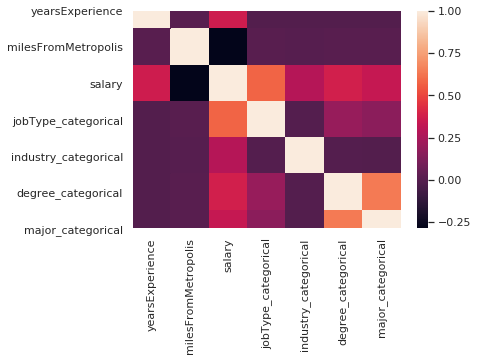

In [157]:
def corr_heatmap(df):
  fig = plt.figure()
  corr = df.corr()
  sns.heatmap(corr)
  fig.savefig("/content/drive/My Drive/Instructions_and_Notebook/corr_map_"+(datetime.now().strftime("%d-%m-%Y %H:%M:%S"))+".png")

corr_heatmap(train_df)

We can see that degree and major fields are very highly correlated hence we can make the decision of dropping one of the fields or just making a single feature out of both of those which can make things easier

In [0]:
train_df["degree_in_major"] = train_df["degree"] +", "+train_df["major"] #Combining both of them in one feature

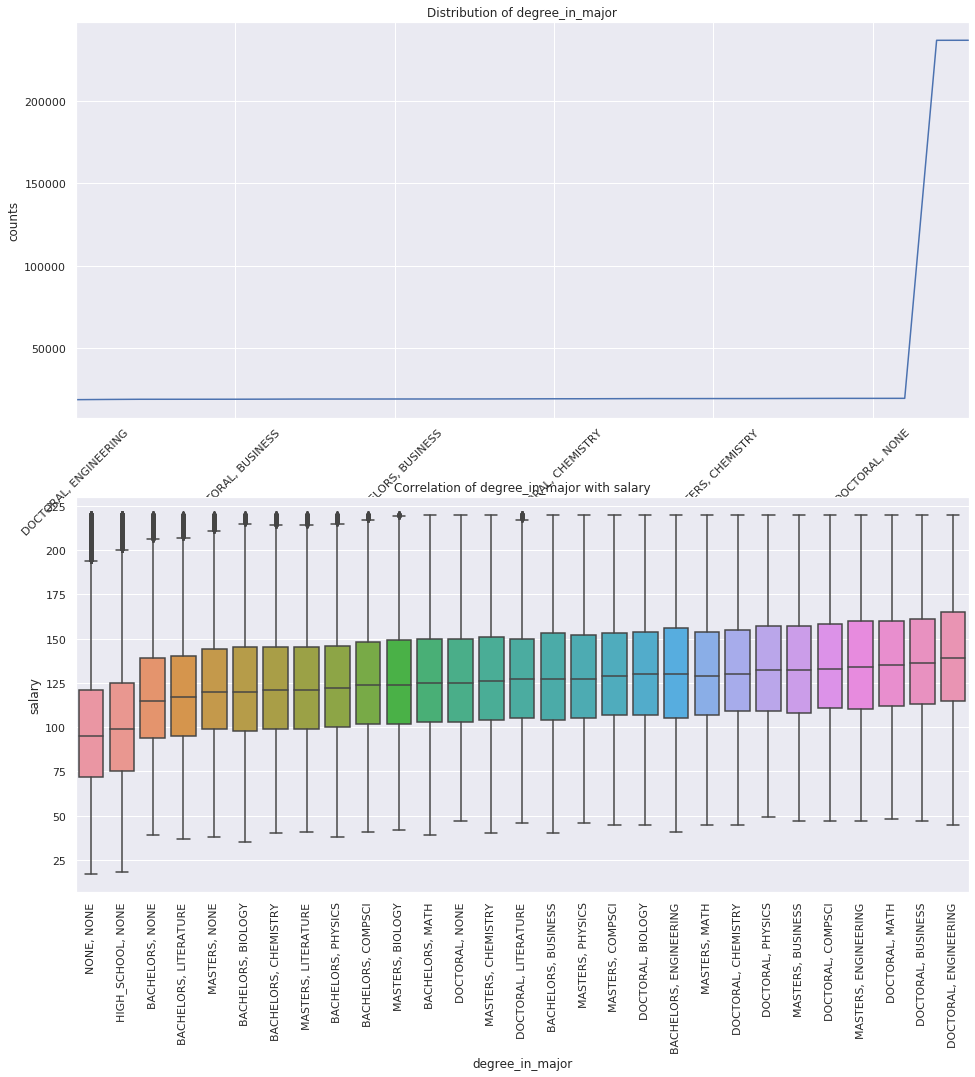

In [159]:
plot_feature(train_df,'degree_in_major','salary')

In [0]:
train_df,degree_major_mapper = ordinal_encode(train_df,'degree_in_major','salary')

We can now drop the features which are not necessary for training the model

In [0]:
features_dropped = ["jobId","companyId","degree","degree_categorical","major","major_categorical","degree_in_major","industry","jobType"]
train_df.drop(features_dropped,axis=1,inplace=True)

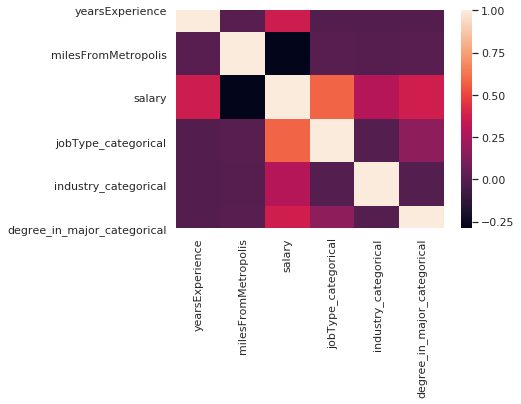

In [163]:
corr_heatmap(train_df)

As we see there is clear correlation once we combine the feature and also we see an issue in the data as major shows as none but the person will have a degree such as a doctoral in 'none'. This is either an entry issue where the major can be defined as 'other' rather than 'none' because having no major is equivalent to having no degree.

### ---- 6 Hypothesize solution ----

In [0]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 
# Any imports should be added here for the machine learning sections

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor


Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc


Some models that can improve the prediction power are

Linear Regression
Polynomial regression
Gradient Boosting on Regressors
Linear Regression can capture a linear equation of the parameters and get a good fit of the data as a line. As we see that there are some linear correlations between the features and the target variable we can represent the

Polynomial Regression will help us explore more complex relationships in data and can also capture non linear relations between data depending on the degree of the data.

Gradient boosting uses a set of models and utilizes the a bunch of weak regressors in sequence which is optimized to improve the accuracy as compared to a single model.


In [0]:
features = train_df.drop("salary",axis=1)
target = train_df.salary

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

We will also create a polynomial dataset which will capture the non linear relationships between data which may lead to a better fit. For this data we will use a degree of 2.

### ---- 7 Engineer features  ----

In [0]:
poly = PolynomialFeatures(degree=2,include_bias=False)
polynomial_features = pd.DataFrame(poly.fit_transform(features),columns = poly.get_feature_names(input_features=features.columns.values),index=features.index)

In [0]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

We will use the following models mentioned in the previous section. To reiterate the models are :
1. Linear Regression.
2. Linear Regression with Polynomial Dataset.
3. Gradient Boosted Regression with the normal and polynomial dataset.
4. Fine Tuned Gradient Regression(Tuned using Grid Search CV) with the normal and polynomial dataset.

We will declare the following models below.

In [0]:
lr = LinearRegression(n_jobs=-1) #Simple linear regression
gb = GradientBoostingRegressor() #Standard default gradient boosting
fine_tuned_model = GradientBoostingRegressor(n_estimators = 350, max_depth = 6) #Found using Grid Search CV 

Now that we have created the models we will be test out the models in cross validation and see the scores. Note that our metric is the mean square error so the lesser the error the better the model is at estimating the salary based on our features.

In [0]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [0]:
#do 5-fold cross validation on models and measure MSE
def score_model(model,features,target,cv=5):
    try:
        return -np.mean(cross_val_score(model,features,target,cv=cv,scoring="neg_mean_squared_error",n_jobs=-1,verbose=1))
    except:
        print("An exception occured pass correct values")
        return

Let us test the linear regression with the base dataset.

In [0]:
score_model(lr,features,target,cv=5)


390.6432501758341

We see that a linear relationship improves the score by a much larger margin as compared to taking the average in each industry i.e 1200 -> 400 . Let us see whether the polynomial data improves the model.

In [0]:
score_model(lr,polynomial_features,target,cv=5)

360.05419223822867

Another good jump is seen when we use the polynomial dataset with linear regression which indicates that there are some non linear correlations with the target. Let's go further with a Gradient Boosting Regressor.

In [0]:
score_model(gb,features,target,cv=5)

352.9165169593929

We see that the Gradient Boosting Regressor also improves on the previous models by reducing the error further. Note that this is done on the non polynomial data set so next we will test out the polynomial data to see whether it improves the scoring.

In [0]:
score_model(gb,polynomial_features,target,cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


354.57924323842684

We see that the error increases so we will not proceed with the polynomial data for this model. We used Grid Search to do some hyperparameter tuning and get a model with the objective of getting the most performance, let's see how well it does on the data after the tuning.

In [0]:
score_model(fine_tuned_model,features,target,cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.2min remaining: 18.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.8min finished


342.032243342995

We see that the fine tuned model does indeed improve the score. Hence we will be using this model in our pipeline.

### ---- 10 Select best model  ----

In [0]:
#select the model with the lowest error as your "production" model
final_model = fine_tuned_model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

Now that we have generated a model which fits the output best we created a pipeline which does the following processes
1. Remove the columns unecessary for modelling.
2. Map the values of categorical variables to according to the correlation with the output.
3. Train a fine tuned model on the data and infer on the test solutions.
4. Save the test inferences in a csv file at the same path where the test file is. 


### ---- 12 Deploy solution ----

In [0]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

def deploy(train_path,train_target_path,test_path):
  class CategoricalTransformer(BaseEstimator,TransformerMixin):
      def __init__( self ):
          self.jobType_map = {'JANITOR': 1,'JUNIOR': 2,'SENIOR': 3,
                          'MANAGER': 4,'VICE_PRESIDENT': 5,
                          'CFO': 6,'CTO': 7,'CEO': 8}
          self.industry_map = {'EDUCATION': 1,'SERVICE': 2,
                               'AUTO': 3,'HEALTH': 4,'WEB': 5,
                               'FINANCE': 6,'OIL': 7}
          self.degree_major_map = {'NONE, NONE': 1,'HIGH_SCHOOL, NONE': 2,
                                   'BACHELORS, NONE': 3,'BACHELORS, LITERATURE': 4,
                                   'MASTERS, NONE': 5,'BACHELORS, BIOLOGY': 6,
                                   'BACHELORS, CHEMISTRY': 7,'MASTERS, LITERATURE': 8,
                                   'BACHELORS, PHYSICS': 9,'BACHELORS, COMPSCI': 10,
                                   'MASTERS, BIOLOGY': 11,'BACHELORS, MATH': 12,
                                   'DOCTORAL, NONE': 13,'MASTERS, CHEMISTRY': 14,
                                   'DOCTORAL, LITERATURE': 15,'BACHELORS, BUSINESS': 16,
                                   'MASTERS, PHYSICS': 17,'MASTERS, COMPSCI': 18,
                                   'DOCTORAL, BIOLOGY': 19,'BACHELORS, ENGINEERING': 20,
                                   'MASTERS, MATH': 21,'DOCTORAL, CHEMISTRY': 22,
                                   'DOCTORAL, PHYSICS': 23,'MASTERS, BUSINESS': 24,
                                   'DOCTORAL, COMPSCI': 25,'MASTERS, ENGINEERING': 26,
                                   'DOCTORAL, MATH': 27,'DOCTORAL, BUSINESS': 28,
                                   'DOCTORAL, ENGINEERING': 29}
          self.data = None
      def fit(self, X, y=None):
        return self
    
      def transform(self, X,y=None):
        X["jobType_encoded"] = X["jobType"].map(self.jobType_map)
        X["industry_encoded"] = X["industry"].map(self.industry_map)
        X["degree_major"] = X["degree"]+ ", " + X["major"]
        X["degree_major_encoded"] = X["degree_major"].map(self.degree_major_map)
        X = X.drop(["jobId","degree","major","industry","degree_major","companyId","jobType"],axis=1)
        return X.values
  categorical_pipeline = Pipeline(steps=[('cat_transformer',CategoricalTransformer())])
  full_pipeline = Pipeline(steps=[('categorical_pipeline',categorical_pipeline),('model',final_model)])
  train_df = pd.read_csv(train_path)
  train_target = pd.read_csv(train_target_path)
  test_df = pd.read_csv(test_path)
  full_pipeline.fit(train_df,train_target.drop("jobId",axis=1))
  test_outcome = pd.DataFrame(test_df.jobId)
  test_outcome["salary"] = full_pipeline.predict(test_df)
  test_outcome.to_csv("/".join(test_path.split("/")[:-1])+"/test_outcome.csv")
  print("Saved to "+ "/".join(test_path.split("/")[:-1])+"/test_outcome.csv")
  return



In [0]:
deploy("/content/drive/My Drive/Instructions_and_Notebook/data/train_features.csv","/content/drive/My Drive/Instructions_and_Notebook/data/train_salaries.csv","/content/drive/My Drive/Instructions_and_Notebook/data/test_features.csv")

Saved to /content/drive/My Drive/Instructions_and_Notebook/data/test_outcome.csv


# Summary

To end with we see that the Gradient Boosting model fits the data the best and is able to get a good error metric of 342 k^2 i.e when we estimate from this model we can say that our salary outcome will be in the range of (-18k,+18k) which is a very reasonable estimate as compared to an industry average perspective.

Also a few features that the dataset can have are :

1. Gender: With the pay scale gap being such an issue these days this feature can make a huge difference in modeling the target variable.
2. Company Jumps: A person changing companies more frequently tends to have a higher salary due to hikes.
3. Years within the company also can be a good factor.

Issues with the data:
1. Outliers : The lower quartile had only 5 records but we also notice that some junior level people getting C-level salaries with very low years of experience hence we need to make sure to drop that data but the other data can be kept as exceptions.
2. None in Major: The data showed Doctoral in None (A mistake on the data entry part) NONE has to be replaced with OTHER.

This always goes that the better the data is the better outcomes.


### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data